# Introduction to ArviZ and PyMC3

You will learn about:

- Exploring the data -- and why it matter
    - What do the data look like?
    - Which natural processes could generate them?
    - A simple, non-Bayesian linear regression
- Linear regression in PyMC3
    - Installing PyMC
    - Coding a model
    - Important PyMC objets
    - Fitting a model
- ArviZ API
    - What’s ArviZ?
    - Analyzing a model
    - Incrementally improving a model
- Missing data imputation
    - What are missing data exactly?
    - How do they appear?
    - How to handle them with PyMC3?
- Out-of-sample predictions
    - Making predictions with new, unobserved data
    - Doing it with PyMC3

https://docs.google.com/document/d/1WGJ9nCGHJUzBcJDhqZB23oKjIg1LS-75dpNCT2BpmJU/edit#heading=h.64ai7yqdr0kg

In [1]:
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

In [2]:
arviz.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

## Exploratory data analysis

In [5]:
fish_market = pd.read_csv("../data/fish-market.csv")
fish_market

Species  Weight  Length1  Length2  Length3   Height   Width
0     Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1     Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2     Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3     Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4     Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
..      ...     ...      ...      ...      ...      ...     ...
154   Smelt    12.2     11.5     12.2     13.4   2.0904  1.3936
155   Smelt    13.4     11.7     12.4     13.5   2.4300  1.2690
156   Smelt    12.2     12.1     13.0     13.8   2.2770  1.2558
157   Smelt    19.7     13.2     14.3     15.2   2.8728  2.0672
158   Smelt    19.9     13.8     15.0     16.2   2.9322  1.8792

[159 rows x 7 columns]

In [4]:
fish_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [5]:
fish_market.describe().round(2)

Weight  Length1  Length2  Length3  Height   Width
count   159.00   159.00   159.00   159.00  159.00  159.00
mean    398.33    26.25    28.42    31.23    8.97    4.42
std     357.98    10.00    10.72    11.61    4.29    1.69
min       0.00     7.50     8.40     8.80    1.73    1.05
25%     120.00    19.05    21.00    23.15    5.94    3.39
50%     273.00    25.20    27.30    29.40    7.79    4.25
75%     650.00    32.70    35.50    39.65   12.37    5.58
max    1650.00    59.00    63.40    68.00   18.96    8.14

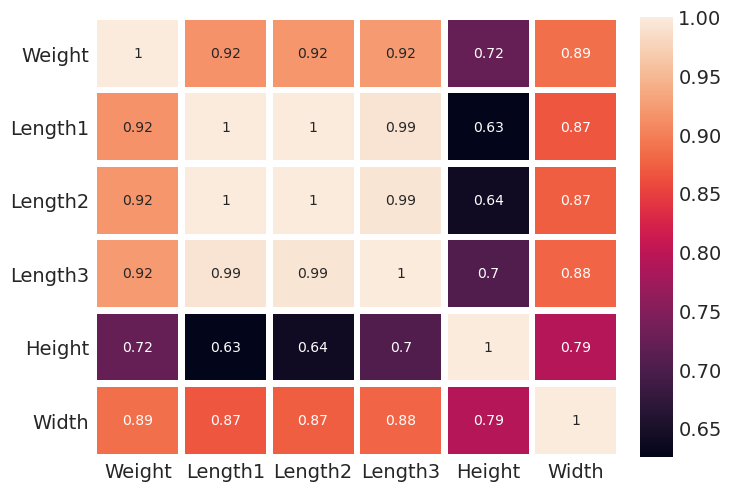

In [6]:
sns.heatmap(fish_market.corr(), annot=True, linewidths=4);

In [6]:
fish_market = fish_market.drop(["Length2", "Length3"], axis="columns")

/Users/alex_andorra/opt/anaconda3/envs/bayes_book/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


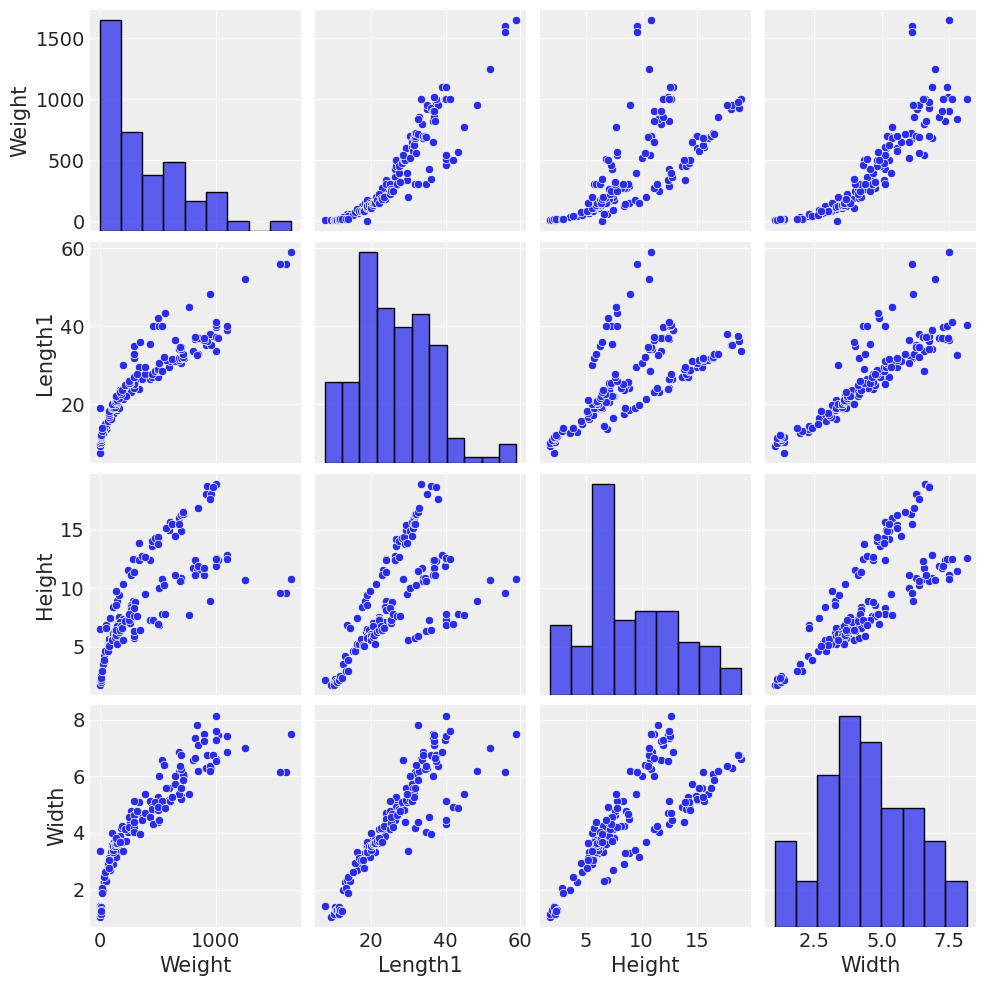

In [7]:
sns.pairplot(data=fish_market);

/Users/alex_andorra/opt/anaconda3/envs/bayes_book/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


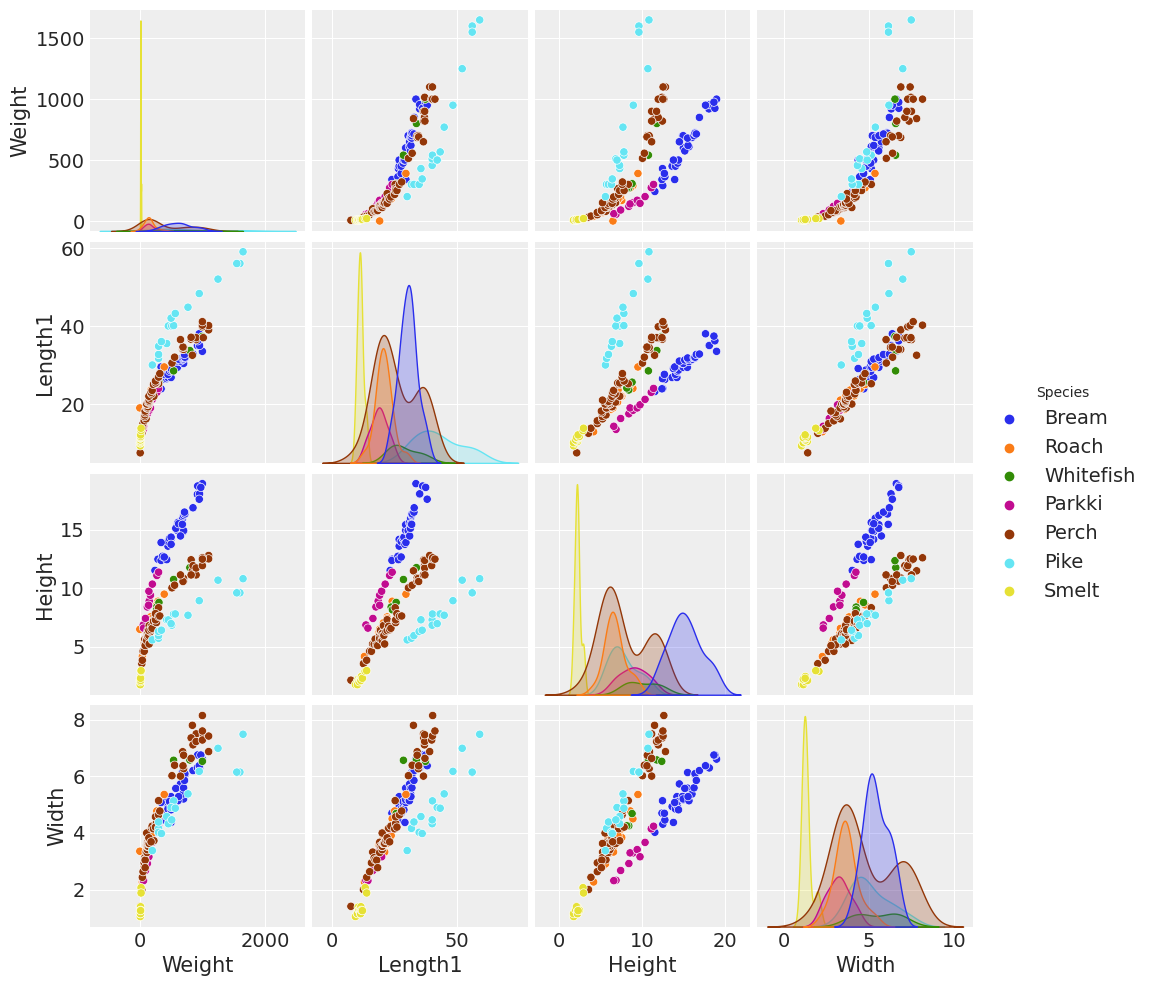

In [8]:
sns.pairplot(data=fish_market, hue="Species");

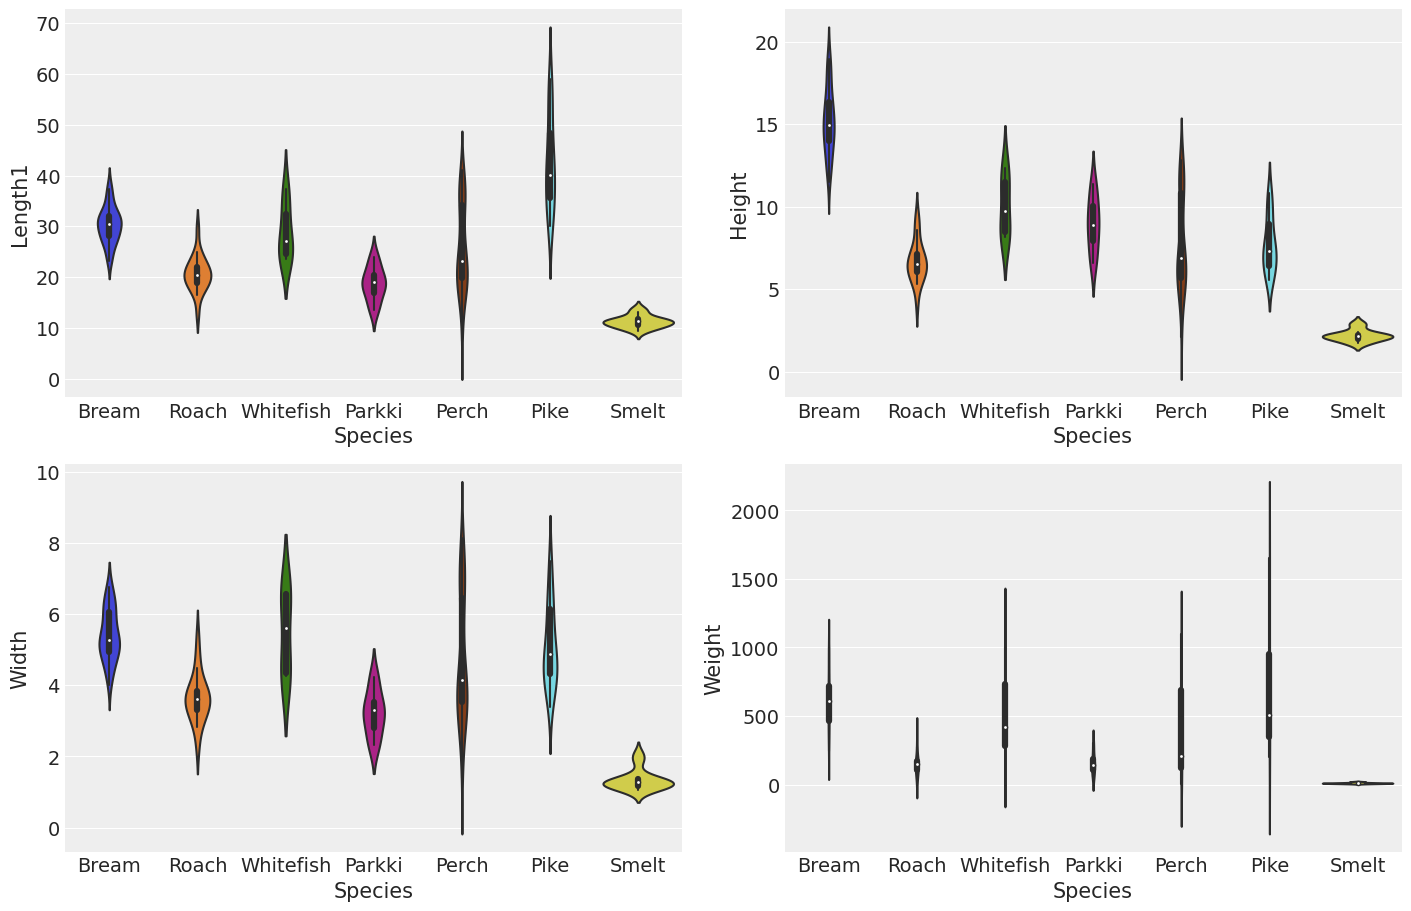

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
for ax, var in zip(axes.ravel(), ["Length1", "Height", "Width", "Weight"]):
    sns.violinplot(x="Species", y=var, data=fish_market, ax=ax)

## Our first linear regression

In [10]:
fish_market["log_width"] = np.log(fish_market.Width)
fish_market["log_height"] = np.log(fish_market.Height)
fish_market["log_length"] = np.log(fish_market.Length1)
fish_market["log_weight"] = np.log(fish_market.Weight)

/Users/alex_andorra/opt/anaconda3/envs/bayes_book/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
fish_reduced = fish_market[fish_market["Weight"] != 0].copy()

/Users/alex_andorra/opt/anaconda3/envs/bayes_book/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


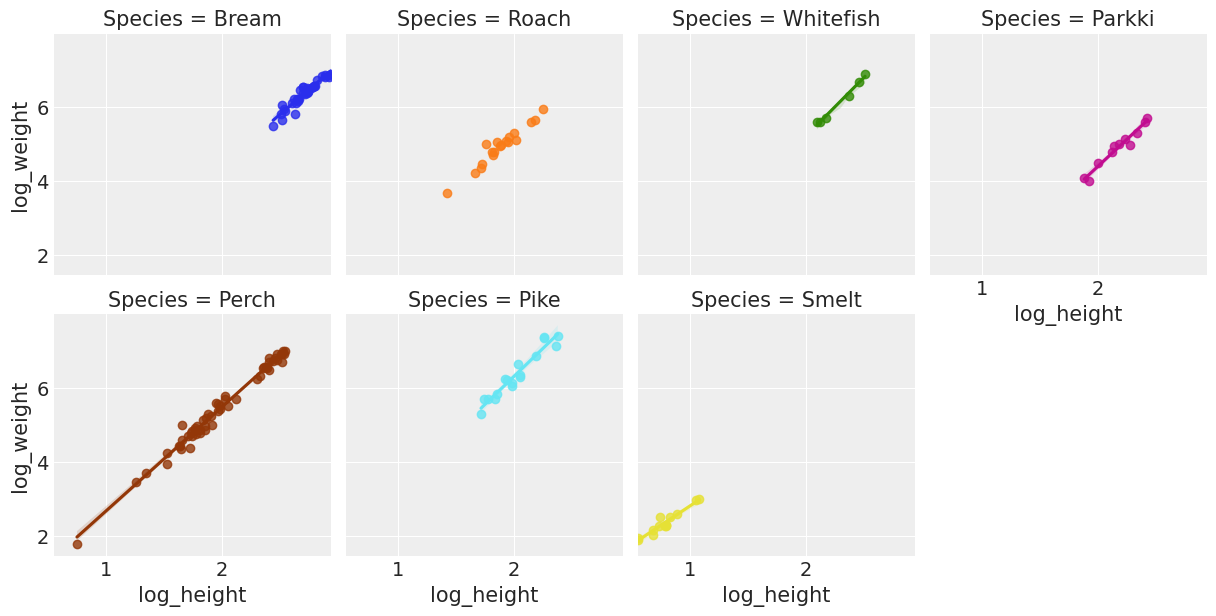

In [12]:
sns.lmplot(
    data=fish_market,
    x="log_height",
    y="log_weight",
    hue="Species",
    col="Species",
    height=3,
    col_wrap=4,
);

## PyMC'ntroduction

### Installing PyMC3

As PyMC3 is an actively developed package, the best practices for installation can sometimes change, so the best resource to be up-to-date is to take a look at the Wikis online. There is one for each platform: [MacOS](https://github.com/pymc-devs/pymc3/wiki/Installation-Guide-(MacOS)), [Windows](https://github.com/pymc-devs/pymc3/wiki/Installation-Guide-(Windows)) and [Linux](https://github.com/pymc-devs/pymc3/wiki/Installation-Guide-(Linux)).

### Coding up a PyMC3 model

In [13]:
with pm.Model() as fish_simple:
    intercept = pm.Normal("intercept")
    sigma = pm.HalfNormal("sigma", 1.0)

    log_obs = pm.Normal(
        "log_weight",
        mu=intercept,
        sigma=sigma,
        observed=fish_reduced.log_weight,
    )

### The `Model` object

Notice that the `Model` above was declared using a `with` statement, a Python idiom known as a context manager.
PyMC uses this idiom to automatically add variables to a model.
Thus, any variable we define is automatically added to the `Model`, without having to explicitly add it.
This avoids the repetitive syntax of `add` functions that you see in some machine learning packages:

```python
model.add(a_variable)
model.add(another_variable)
model.add(yet_another_variable)
model.add(are_you_kiddin_me)
model.add(please_kill_me_now)
```

In fact, PyMC variables cannot be defined without a corresponding `Model`:

In [14]:
uh_oh = pm.Normal('uh_oh')

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

However, variables can be explicitly added to models without the use of a context manager, via the variable's optional `model` argument:

```python
fish_model = pm.Model()
intercept = pm.Normal('intercept', model=fish_model)
```

Or, if we just want a standard Normal distribution, and do not need to use it in a PyMC3 model necessarily, we can create one using the `dist` classmethod:

In [15]:
x = pm.Normal.dist()
type(x)

pymc3.distributions.continuous.Normal

### `Model` attributes

Let's have a look at the model's attributes to see what we have.
The stochastic nodes are identified in the `vars` (i.e. variables) attribute:

In [16]:
fish_simple.vars

[intercept ~ Normal, sigma_log__ ~ TransformedDistribution]

In [17]:
fish_simple.deterministics

[sigma ~ HalfNormal]

### PyMC3 variables

In [19]:
intercept.dtype, log_obs.dtype

('float64', 'float64')

In [20]:
intercept.init_value, sigma.init_value

(array(0.), array(0.79788456))

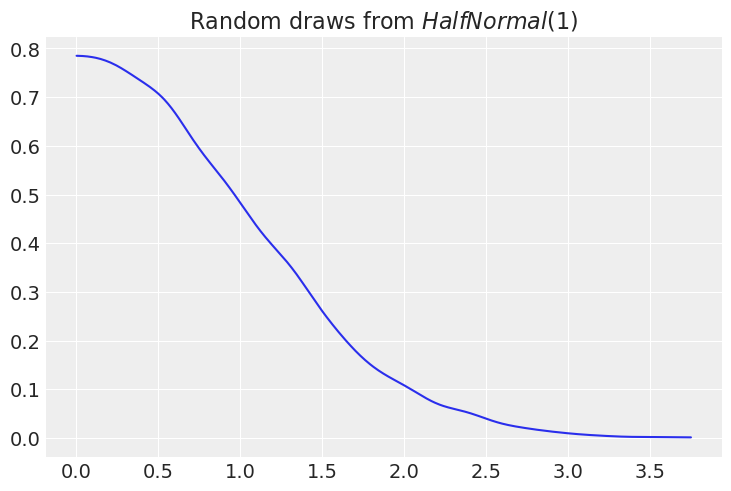

In [21]:
ax = arviz.plot_dist(sigma.random(size=10_000))
ax.set_title("Random draws from $HalfNormal(1)$");

In [22]:
sigma.transformed

sigma_log__ ~ TransformedDistribution

In [23]:
sigma

sigma ~ HalfNormal

In [25]:
type(intercept), type(sigma), type(log_obs)

(pymc3.model.FreeRV, pymc3.model.TransformedRV, pymc3.model.ObservedRV)

### Log-probabilities of variables

In [26]:
intercept.logp({"intercept": 0, "sigma_log__": 1})

array(-0.91893853)

In [27]:
log_obs.logp({"intercept": 0, "sigma_log__": 1})

array(-634.79495429)

### Fitting the model

Now is time to get our hands dirty by sampling from our model! PyMC3's `sample` function will fit probability models (which are no more than linked collections of variables) like ours using Markov chain Monte Carlo (MCMC) sampling. Unless we manually assign particular algorithms to variables in our model, PyMC will assign algorithms that it deems appropriate (it usually does a decent job of this).

In [32]:
with fish_simple:
    idata_simple = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)
    idata_simple.extend(
        arviz.from_pymc3(
            prior=pm.sample_prior_predictive(),
            posterior_predictive=pm.sample_posterior_predictive(idata_simple),
        )
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


## ArviZ, for the explorers (of Bayesian models)

In short, ArviZ is your friend for all pre- and post-processing modeling steps, which happen to be very common, no matter the probabilistic language you use (Stan, PyMC, Numpyro, TensorFlow Probability, etc.). To that end, ArviZ converts results from any of those libraries into a common data structure, called `InferenceData`. It also provides functions to check model convergence, diagnose and criticize models, compare different models, and flexibly plot the results (using either Matplotlib or Bokeh). These tasks are also key to the modelling process and require both numerical and visual tools.

Concretely, `InferenceData` objects contain all relevant information to perform diagnostics on the inference run or to reproduce it -- which means you can share your analysis with your colleagues, aka _the_ dream of any Bayesian. These objects contain several groups, each of which is a multidimensional-labeled array with one or more data variables, as shown in the figure below:

![image](../images/InferenceDataStructure.png)

These groups contain data related to a specific collection such as _posterior_, _observed data_, or _sampler stats_ (sampler quantities like divergence, tree depth, and log likelihood).
The full schema specification can be found in [ArviZ's documentation](https://arviz-devs.github.io/arviz/schema/schema.html) and is useful to parse through.

In [29]:
idata_simple

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> posterior_predictive
	> prior
	> prior_predictive

In [31]:
idata_simple.posterior.intercept.sel(chain=0)

<xarray.DataArray 'intercept' (draw: 1000)>
array([5.27912297, 5.32363504, 5.40024273, 5.31789506, 5.31789506,
       5.31196934, 5.29238353, 5.28002099, 5.3152586 , 5.21518999,
       5.48244844, 5.37370266, 5.37370266, 5.30382278, 5.28225937,
       5.2363278 , 5.50773005, 5.56172914, 5.07502935, 5.64863598,
       5.38823254, 5.23715111, 5.56203268, 5.1857827 , 5.23216114,
       5.14914561, 5.13558604, 5.53577871, 5.24763439, 5.44718392,
       5.42197738, 5.29919785, 5.29919785, 5.23042405, 5.25480457,
       5.25480457, 5.42963512, 5.36084274, 5.36084274, 5.35507863,
       5.47869568, 5.43206342, 5.42200358, 5.25716123, 5.41070791,
       5.32915212, 5.34233162, 5.34233162, 5.25251825, 5.35760736,
       5.19139995, 5.18185551, 5.53212625, 5.21490251, 5.4906899 ,
       5.38555797, 5.35444612, 5.35444612, 5.44288822, 5.32324977,
       5.29431712, 5.42282733, 5.30740074, 5.50765723, 5.34238757,
       5.32732128, 5.30598425, 5.33439743, 5.38934749, 5.29870789,
       5.35893469, 5.3991674 , 5.42423324, 5.36143639, 5.37953235,
       5.12604219, 5.5234411 , 5.47587889, 5.37224987, 5.3433627 ,
       5.3433627 , 5.41280541, 5.39361735, 5.21374634, 5.21250033,
       5.47981425, 5.60088986, 5.61565088, 5.56002928, 5.41557141,
       5.39190944, 5.38154308, 5.40033886, 5.30389052, 5.20103963,
       5.40505707, 5.29531317, 5.36187363, 5.45870705, 5.17210322,
...
       5.56858361, 5.1665098 , 5.25926117, 5.25926117, 5.2428692 ,
       5.42360073, 5.19041425, 5.59989103, 5.12535076, 5.26196672,
       5.40687708, 5.45016796, 5.22494625, 5.20000574, 5.25973568,
       5.40857331, 5.44150003, 5.34306333, 5.40211057, 5.26428624,
       5.35452716, 5.39170983, 5.34748732, 5.32370885, 5.27800403,
       5.28342088, 5.2762585 , 5.51321222, 5.41274642, 5.26871459,
       5.30550305, 5.30550305, 5.25208958, 5.33382135, 5.29207131,
       5.41399463, 5.38814015, 5.19887965, 5.35195364, 5.26075125,
       5.36751581, 5.29273947, 5.13006778, 5.13006778, 5.24148025,
       5.46219029, 5.26569778, 5.22656049, 5.32794007, 5.33938501,
       5.31263519, 5.25053878, 5.1097842 , 5.16367009, 5.25040224,
       5.35844528, 5.36389493, 5.34168647, 5.3712742 , 5.25791302,
       5.34779505, 5.34779505, 5.41862001, 5.09890652, 5.18276836,
       5.1212758 , 5.06502148, 5.61465885, 5.51787111, 5.23640184,
       5.29875149, 5.5148233 , 5.51108482, 5.35533188, 5.3841208 ,
       5.3841208 , 5.5030781 , 5.43392948, 5.31321193, 5.45904591,
       5.33672279, 5.33672279, 5.47322919, 5.2931271 , 5.43210356,
       5.32913476, 5.35887076, 5.40958528, 5.53186855, 5.33182965,
       5.36249645, 5.39365351, 5.39365351, 5.33155047, 5.33155047,
       5.30160444, 5.40564574, 5.2835493 , 5.35725889, 5.16998709])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

`InferenceData` objects are so central to ArviZ that most functions take it as an input. For more details, you can take a look at the [getting started guide](https://arviz-devs.github.io/arviz/getting_started/index.html) on ArviZ website.

## Using ArviZ to analyze a model

In [33]:
arviz.summary(idata_simple, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  5.35  0.11    5.16     5.56        0.0      0.0   3569.96   
sigma      1.33  0.08    1.18     1.46        0.0      0.0   3405.46   

           ess_tail  r_hat  
intercept   2541.37    1.0  
sigma       2845.79    1.0

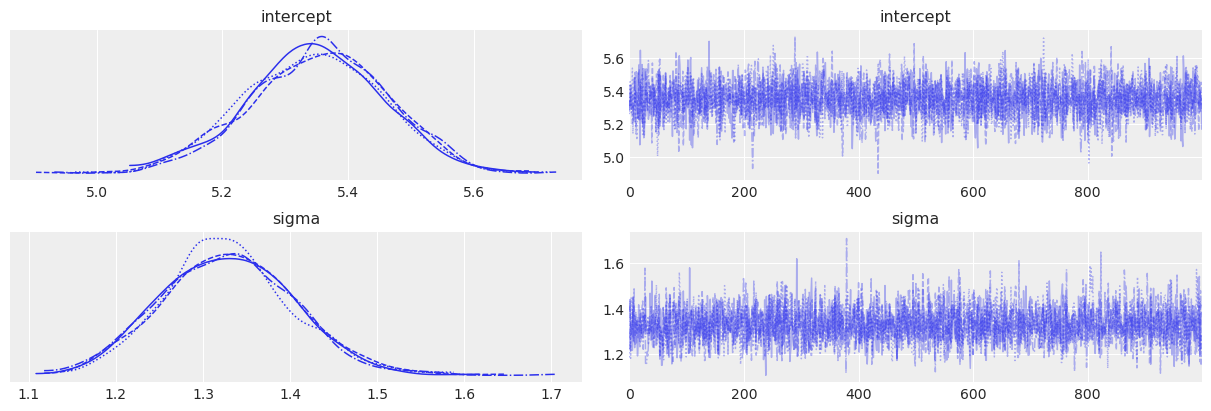

In [34]:
arviz.plot_trace(idata_simple);

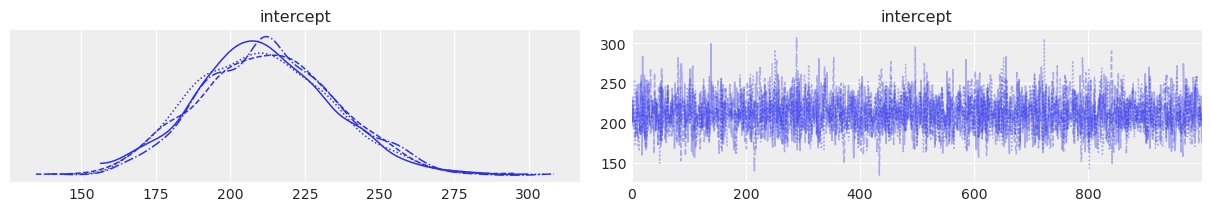

In [36]:
arviz.plot_trace(idata_simple, transform=np.exp, var_names="intercept");

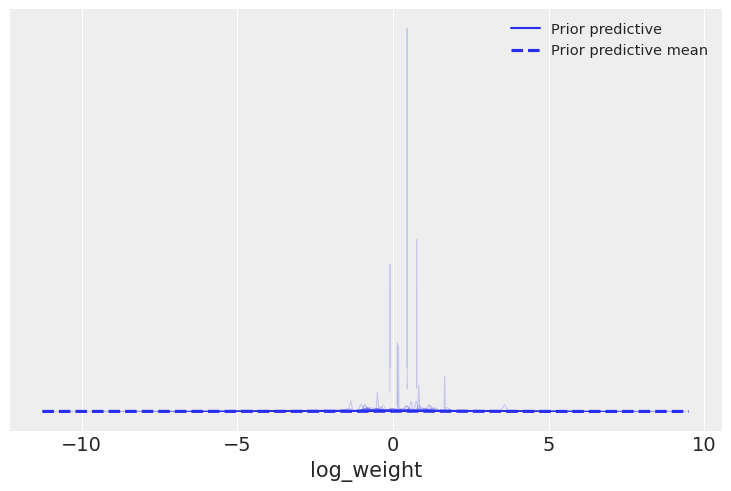

In [37]:
arviz.plot_ppc(idata_simple, group="prior", observed=False);

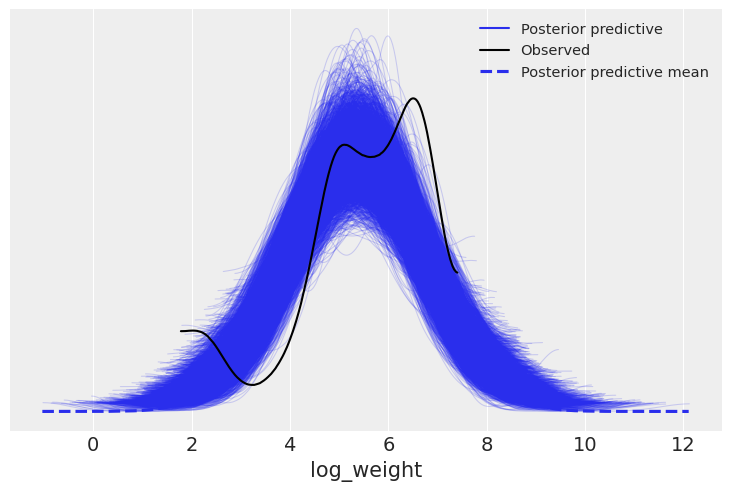

In [38]:
arviz.plot_ppc(idata_simple);

Well that's not good... There are clearly several populations in these data, and our model is unable to pick them up. That's probably why it needs a large posterior uncertainty and observational noise (`sigma`) -- that way, it can encompass everything.

We should allow our model to behave differently for each species. Can you guess how it's called? Yep, it's an unpooled model, where we basically fit as many different regressions as there are species.

In [39]:
species_idx, species = fish_reduced.Species.factorize(sort=True)
COORDS = {
    "coeffs": ["width_effect", "height_effect", "length_effect"],
    "species": species
}

In [40]:
with pm.Model(coords=COORDS) as fish_unpooled:
    intercept = pm.Normal("intercept", sigma=1.0, dims="species")
    β = pm.Normal("β", sigma=0.5, dims=("coeffs", "species"))

    mu = (
        intercept[species_idx]
        + β[0, species_idx] * fish_reduced.log_width
        + β[1, species_idx] * fish_reduced.log_height
        + β[2, species_idx] * fish_reduced.log_length
    )
    sigma = pm.HalfNormal("sigma", 1.0)

    log_obs = pm.Normal(
        "log_weight",
        mu=mu,
        sigma=sigma,
        observed=fish_reduced.log_weight,
    )

    idata_unpooled = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)
    idata_unpooled.extend(
        arviz.from_pymc3(
            prior=pm.sample_prior_predictive(),
            posterior_predictive=pm.sample_posterior_predictive(idata_unpooled),
        )
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, β, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.


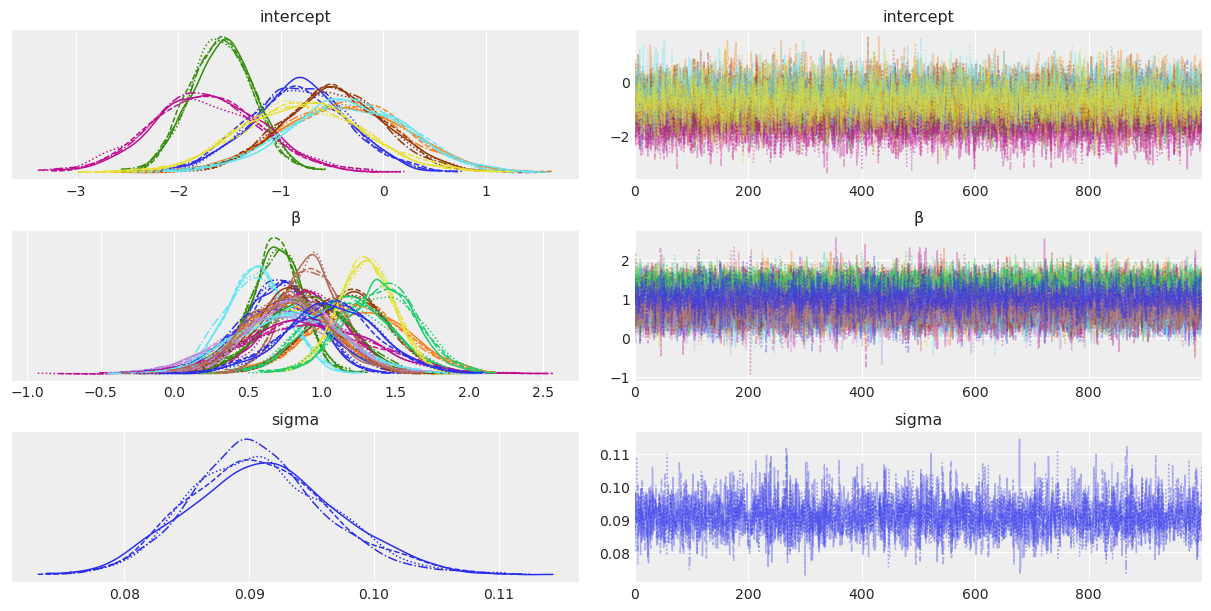

In [41]:
arviz.plot_trace(idata_unpooled);

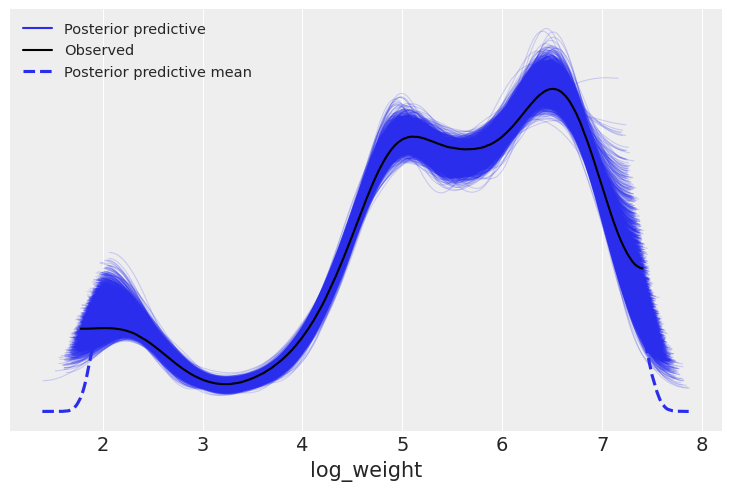

In [42]:
arviz.plot_ppc(idata_unpooled);

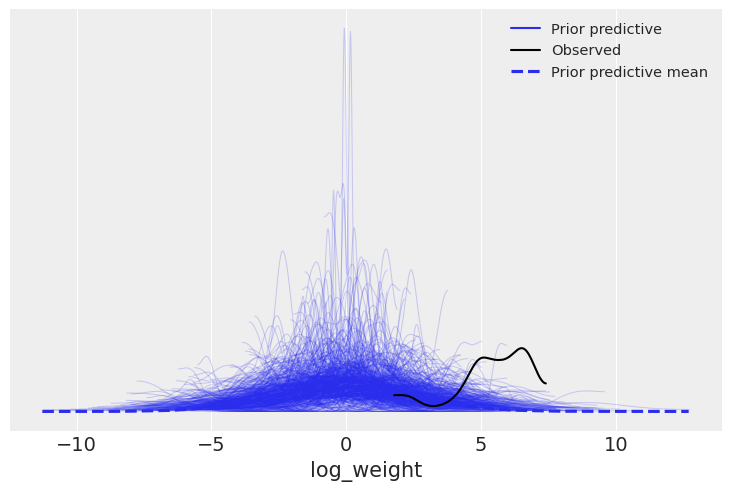

In [43]:
arviz.plot_ppc(idata_unpooled, group="prior");

## Imputing missing data

More often than not, your data will be flawed in some way -- measurement error, human error, etc. -- leading them to take on weird values or being downright missing. We saw one such case earlier with this dataset: one of the observed fish is reported to have weight... zero. We dealt with this idiosyncrasy by the simplest way possible: we just removed the observation from our dataset.

But this wastes information and can bias our inference. We can do better and _infer_ the missing weight value thanks to all our other, completely observed data -- pretty cool, huh? 

Even cooler: PyMC3 does that for you automatically! Let us show that to you. Let's say we have even more missing weights than the one we already have. To that end, let's say that 10% of the dataset has a log weight of -infinity (i.e a weight of 0):

In [44]:
fish_nans = fish_market.copy()
nan_idx = fish_nans.sample(frac=0.1, random_state=92).sort_index().index
fish_nans.loc[nan_idx, "log_weight"] = -np.inf

In [45]:
fish_nans.loc[nan_idx]

Species  Weight  Length1   Height   Width  log_width  log_height  \
22       Bream   620.0     31.5  15.5227  5.2801   1.663945    2.742303   
24       Bream   700.0     31.9  16.2405  5.5890   1.720800    2.787508   
32       Bream   925.0     36.2  18.7542  6.7497   1.909498    2.931418   
35       Roach    40.0     12.9   4.1472  2.2680   0.818898    1.422433   
55   Whitefish   270.0     23.6   8.3804  4.2476   1.446354    2.125896   
61      Parkki    55.0     13.5   6.8475  2.3265   0.844365    1.923884   
70      Parkki   273.0     23.0  11.0880  4.1440   1.421662    2.405863   
73       Perch    32.0     12.5   3.5280  1.9992   0.692747    1.260731   
74       Perch    40.0     13.8   3.8240  2.4320   0.888714    1.341297   
81       Perch    85.0     18.2   5.0820  2.7720   1.019569    1.625705   
83       Perch   115.0     19.0   5.9175  3.3075   1.196193    1.777914   
98       Perch   188.0     22.6   6.7334  4.1658   1.426908    1.907080   
101      Perch   218.0     25.0   7.1680  4.1440   1.421662    1.969627   
106      Perch   250.0     25.9   7.8204  4.2042   1.436084    2.056736   
113      Perch   700.0     34.0  10.6091  6.7408   1.908179    2.361712   
145      Smelt     6.7      9.3   1.7388  1.0476   0.046502    0.553195   

     log_length  log_weight  
22     3.449988        -inf  
24     3.462606        -inf  
32     3.589059        -inf  
35     2.557227        -inf  
55     3.161247        -inf  
61     2.602690        -inf  
70     3.135494        -inf  
73     2.525729        -inf  
74     2.624669        -inf  
81     2.901422        -inf  
83     2.944439        -inf  
98     3.117950        -inf  
101    3.218876        -inf  
106    3.254243        -inf  
113    3.526361        -inf  
145    2.230014        -inf

In [46]:
species_idx, species = fish_nans.Species.factorize(sort=True)
COORDS["species"] = species

In [47]:
with pm.Model(coords=COORDS) as fish_unpooled_missing:
    intercept = pm.Normal("intercept", sigma=1.0, dims="species")
    β = pm.Normal("β", sigma=0.5, dims=("coeffs", "species"))

    mu = (
        intercept[species_idx]
        + β[0, species_idx] * fish_nans.log_width
        + β[1, species_idx] * fish_nans.log_height
        + β[2, species_idx] * fish_nans.log_length
    )
    sigma = pm.HalfNormal("sigma", 1.0)

    log_obs = pm.Normal(
        "log_weight",
        mu=mu,
        sigma=sigma,
        observed=np.ma.masked_invalid(fish_nans["log_weight"]),
    )

    idata_unpooled_missing = pm.sample(
        return_inferencedata=True, random_seed=RANDOM_SEED, target_accept=0.9
    )

/Users/alex_andorra/opt/anaconda3/envs/bayes_book/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in log_weight contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_weight_missing, sigma, β, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 184 seconds.


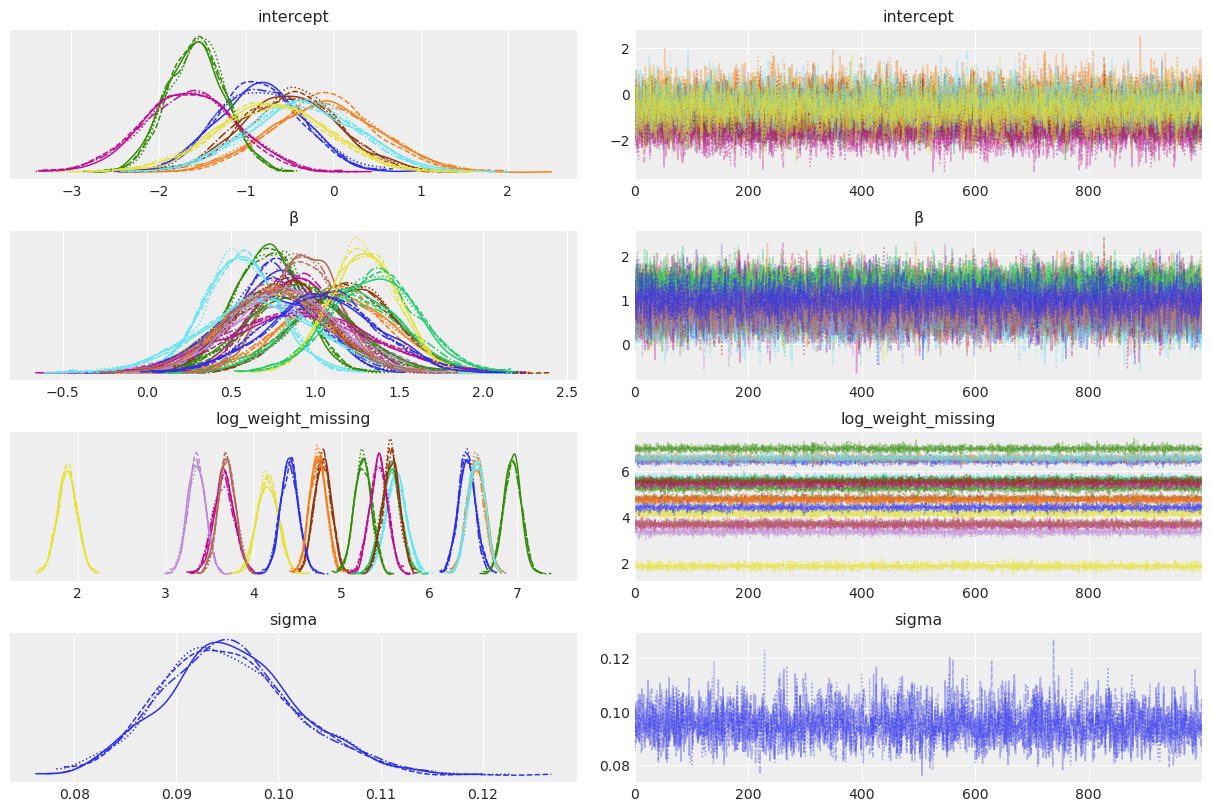

In [48]:
arviz.plot_trace(idata_unpooled_missing);

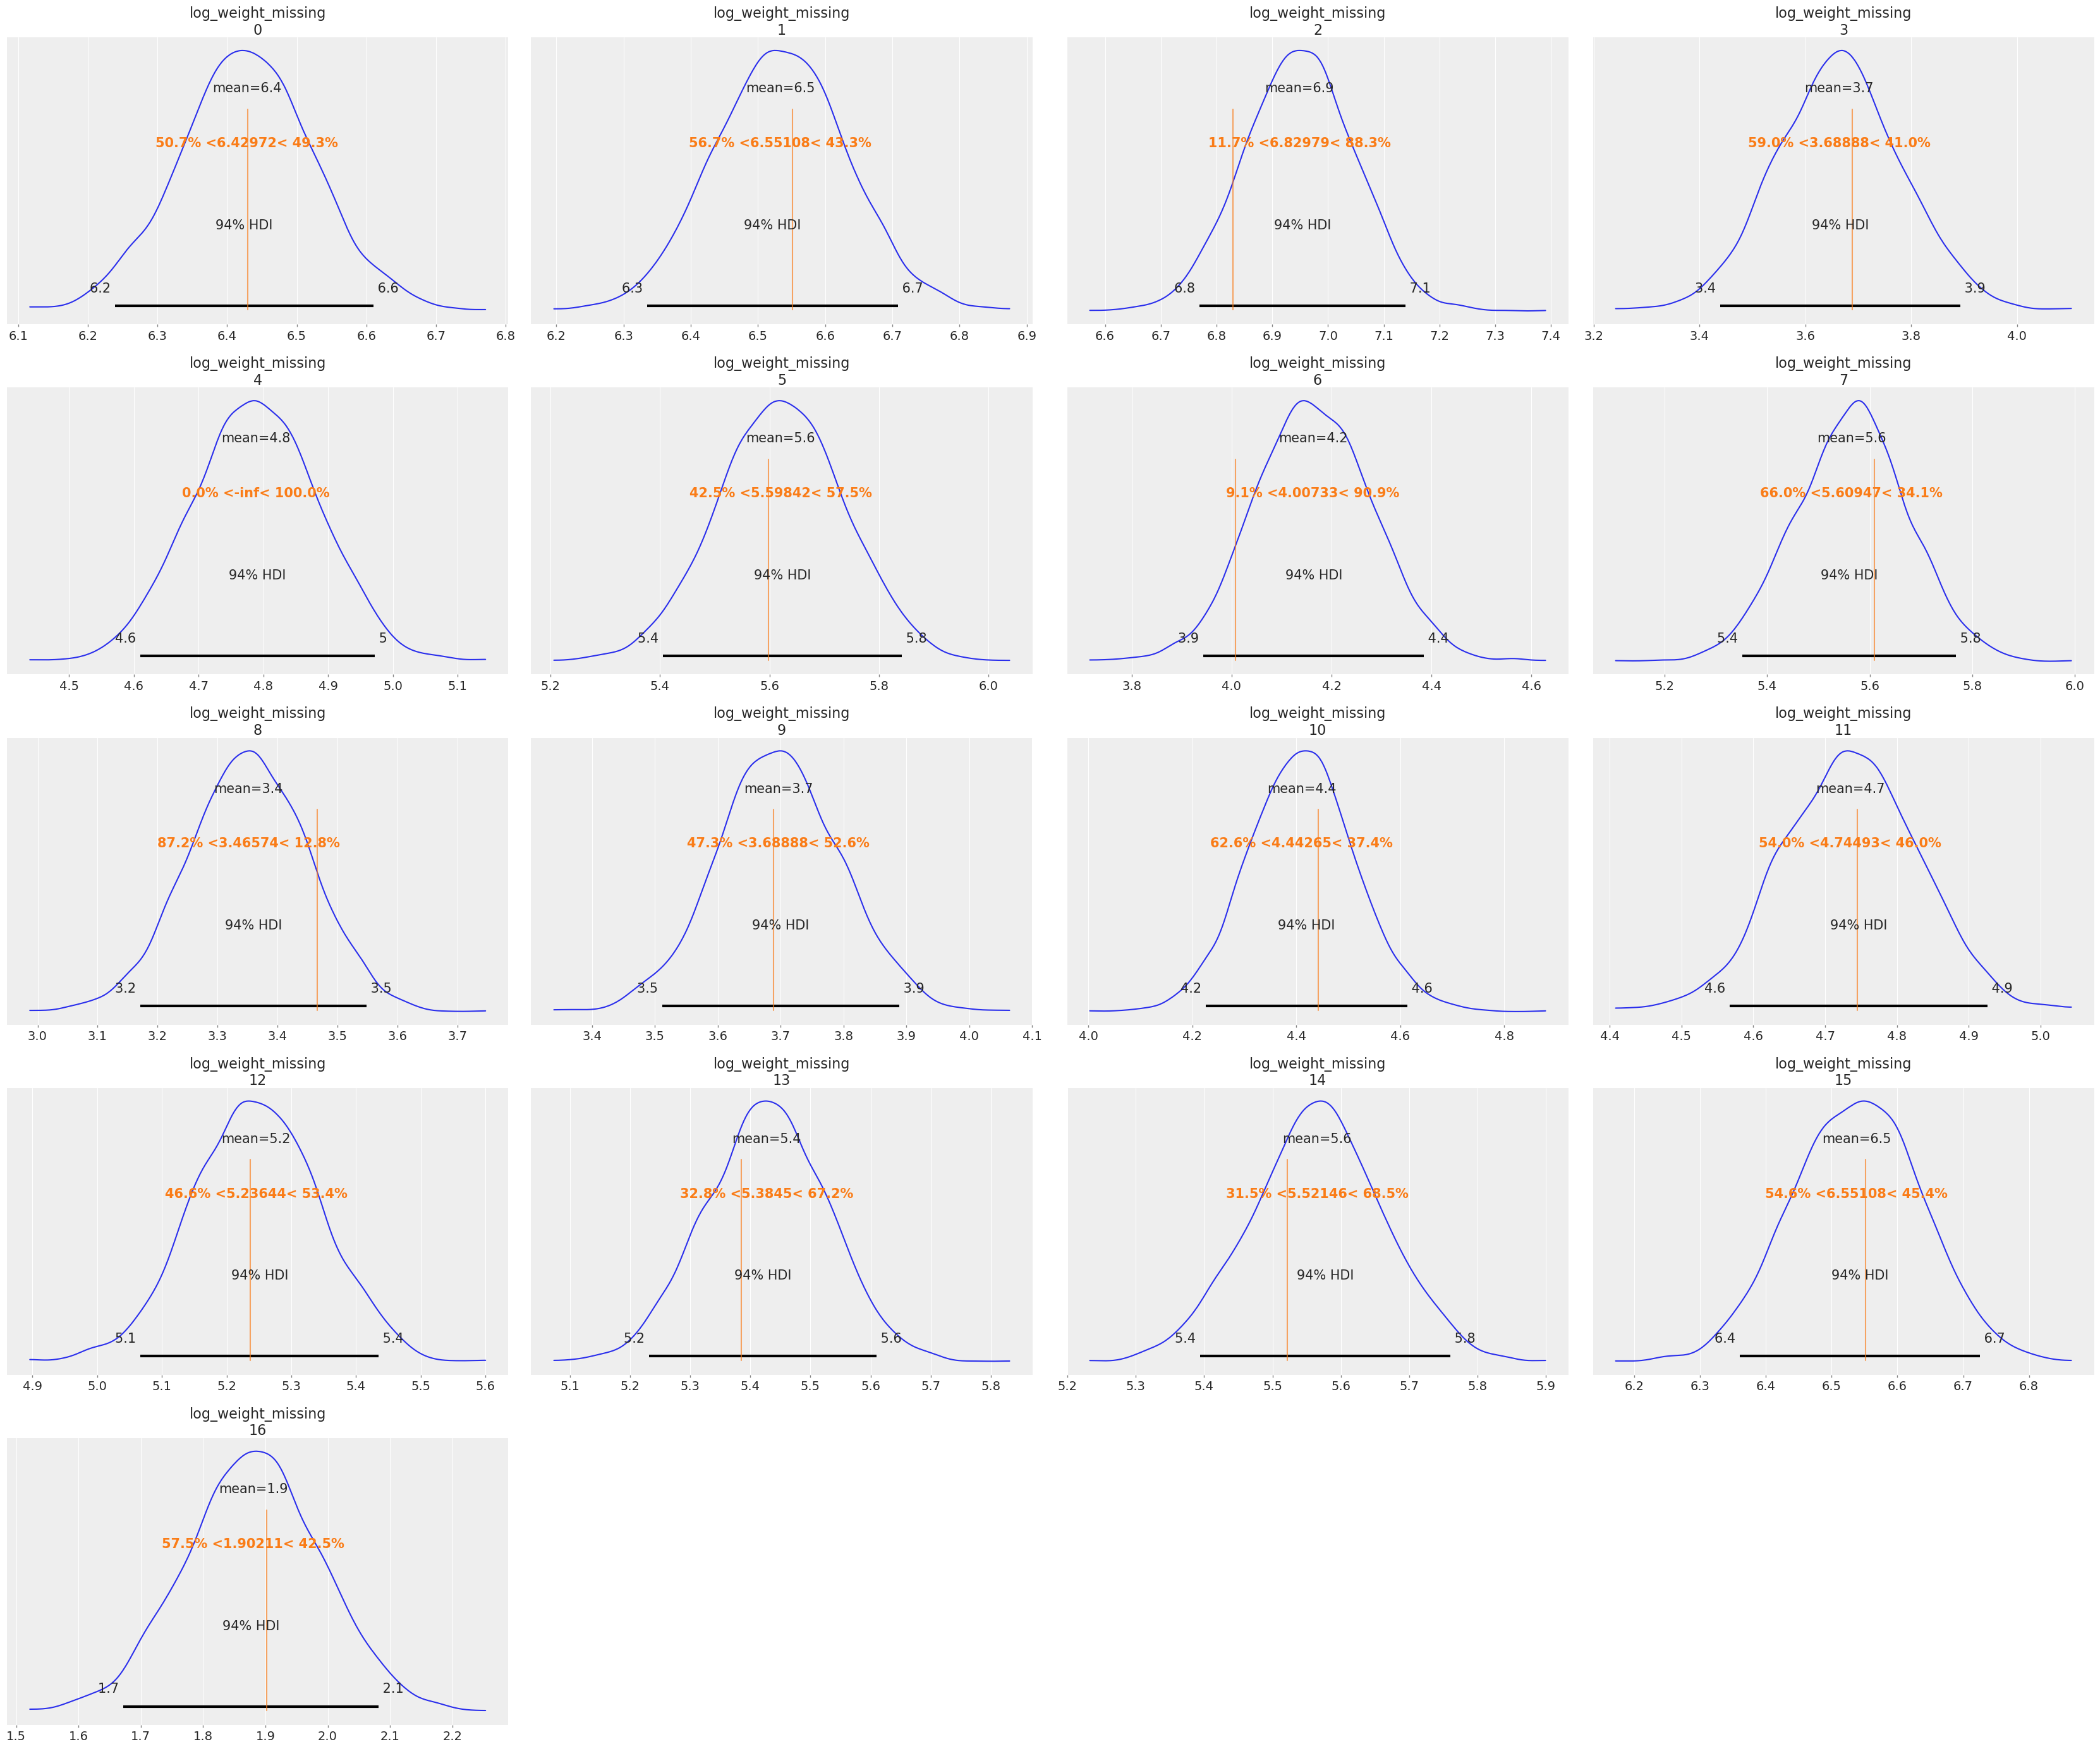

In [49]:
arviz.plot_posterior(
    idata_unpooled_missing,
    var_names=["log_weight_missing"],
    ref_val=fish_market.loc[fish_nans["log_weight"] == -np.inf, "log_weight"].tolist(),
);

## Predicting out-of-sample

A common use case in a statistical workflow is to make predictions with new, unobserved data, which are poetically called "out-of-sample" data. To do that in PyMC3, the easiest is to use the `Data` container, which makes PyMC3 and ArviZ aware of the data the model was trained on, which means you'll be able to change them later on. 

To demonstrate this functionality, we'll now cut out the fish that were missing in our previous example. The model will never see them before doing out-of-sample predictions:

In [50]:
fish_cut = fish_reduced.copy()
fish_cut = fish_cut[fish_nans["log_weight"] != -np.inf]

<ipython-input-50-6e7329b831af>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fish_cut = fish_cut[fish_nans["log_weight"] != -np.inf]


In [51]:
species_idx, species = fish_cut.Species.factorize(sort=True)
COORDS["species"] = species

In [52]:
with pm.Model(coords=COORDS) as fish_unpooled_oos:
    intercept = pm.Normal("intercept", sigma=1.0, dims="species")
    β = pm.Normal("β", sigma=0.5, dims=("coeffs", "species"))

    log_width = pm.Data("log_width", fish_cut.log_width)
    log_height = pm.Data("log_height", fish_cut.log_height)
    log_length = pm.Data("log_length", fish_cut.log_length)
    species_idx_ = pm.Data("species_idx", species_idx)

    mu = (
        intercept[species_idx_]
        + β[0, species_idx_] * log_width
        + β[1, species_idx_] * log_height
        + β[2, species_idx_] * log_length
    )
    sigma = pm.HalfNormal("sigma", 1.0)

    _ = pm.Normal(
        "log_weight",
        mu=mu,
        sigma=sigma,
        observed=fish_cut.log_weight,
    )

    idata_unpooled_oos = pm.sample(
        return_inferencedata=True, random_seed=RANDOM_SEED, target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, β, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 193 seconds.


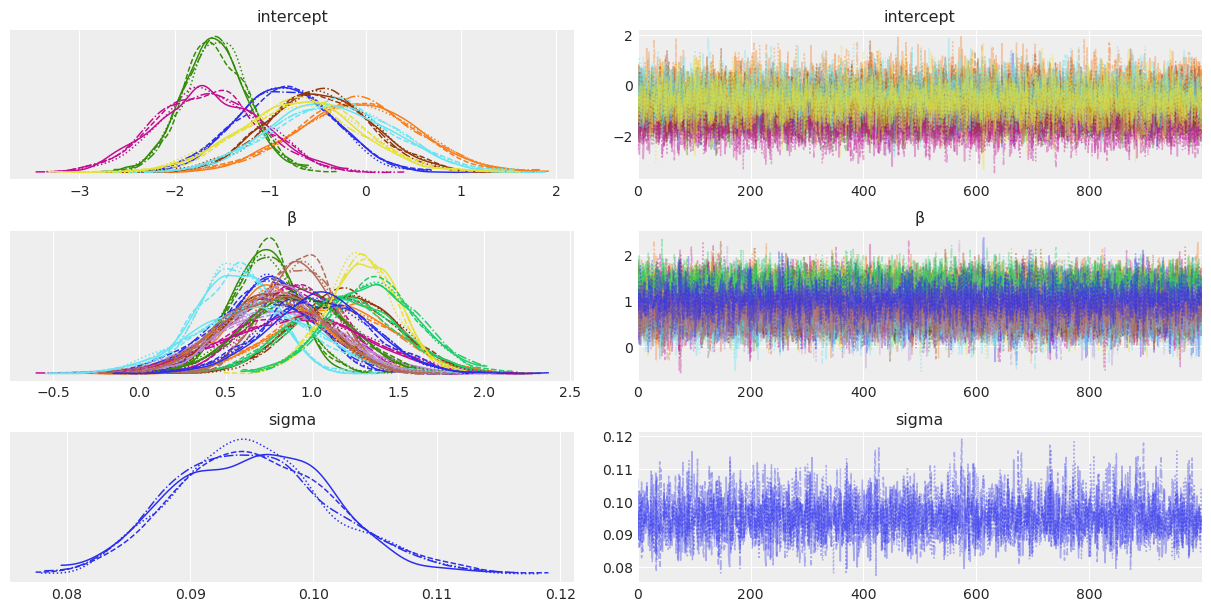

In [53]:
arviz.plot_trace(idata_unpooled_oos);

In [54]:
oos_data = fish_nans.loc[nan_idx]

In [55]:
with fish_unpooled_oos:
    pm.set_data(
        {
            "log_height": oos_data.log_height,
            "log_length": oos_data.log_length,
            "log_width": oos_data.log_width,
            "species_idx": oos_data.Species.factorize(sort=True)[0],
        }
    )

    idata_unpooled_oos.extend(
        arviz.from_pymc3(
            posterior_predictive=pm.sample_posterior_predictive(idata_unpooled_oos),
        )
    )

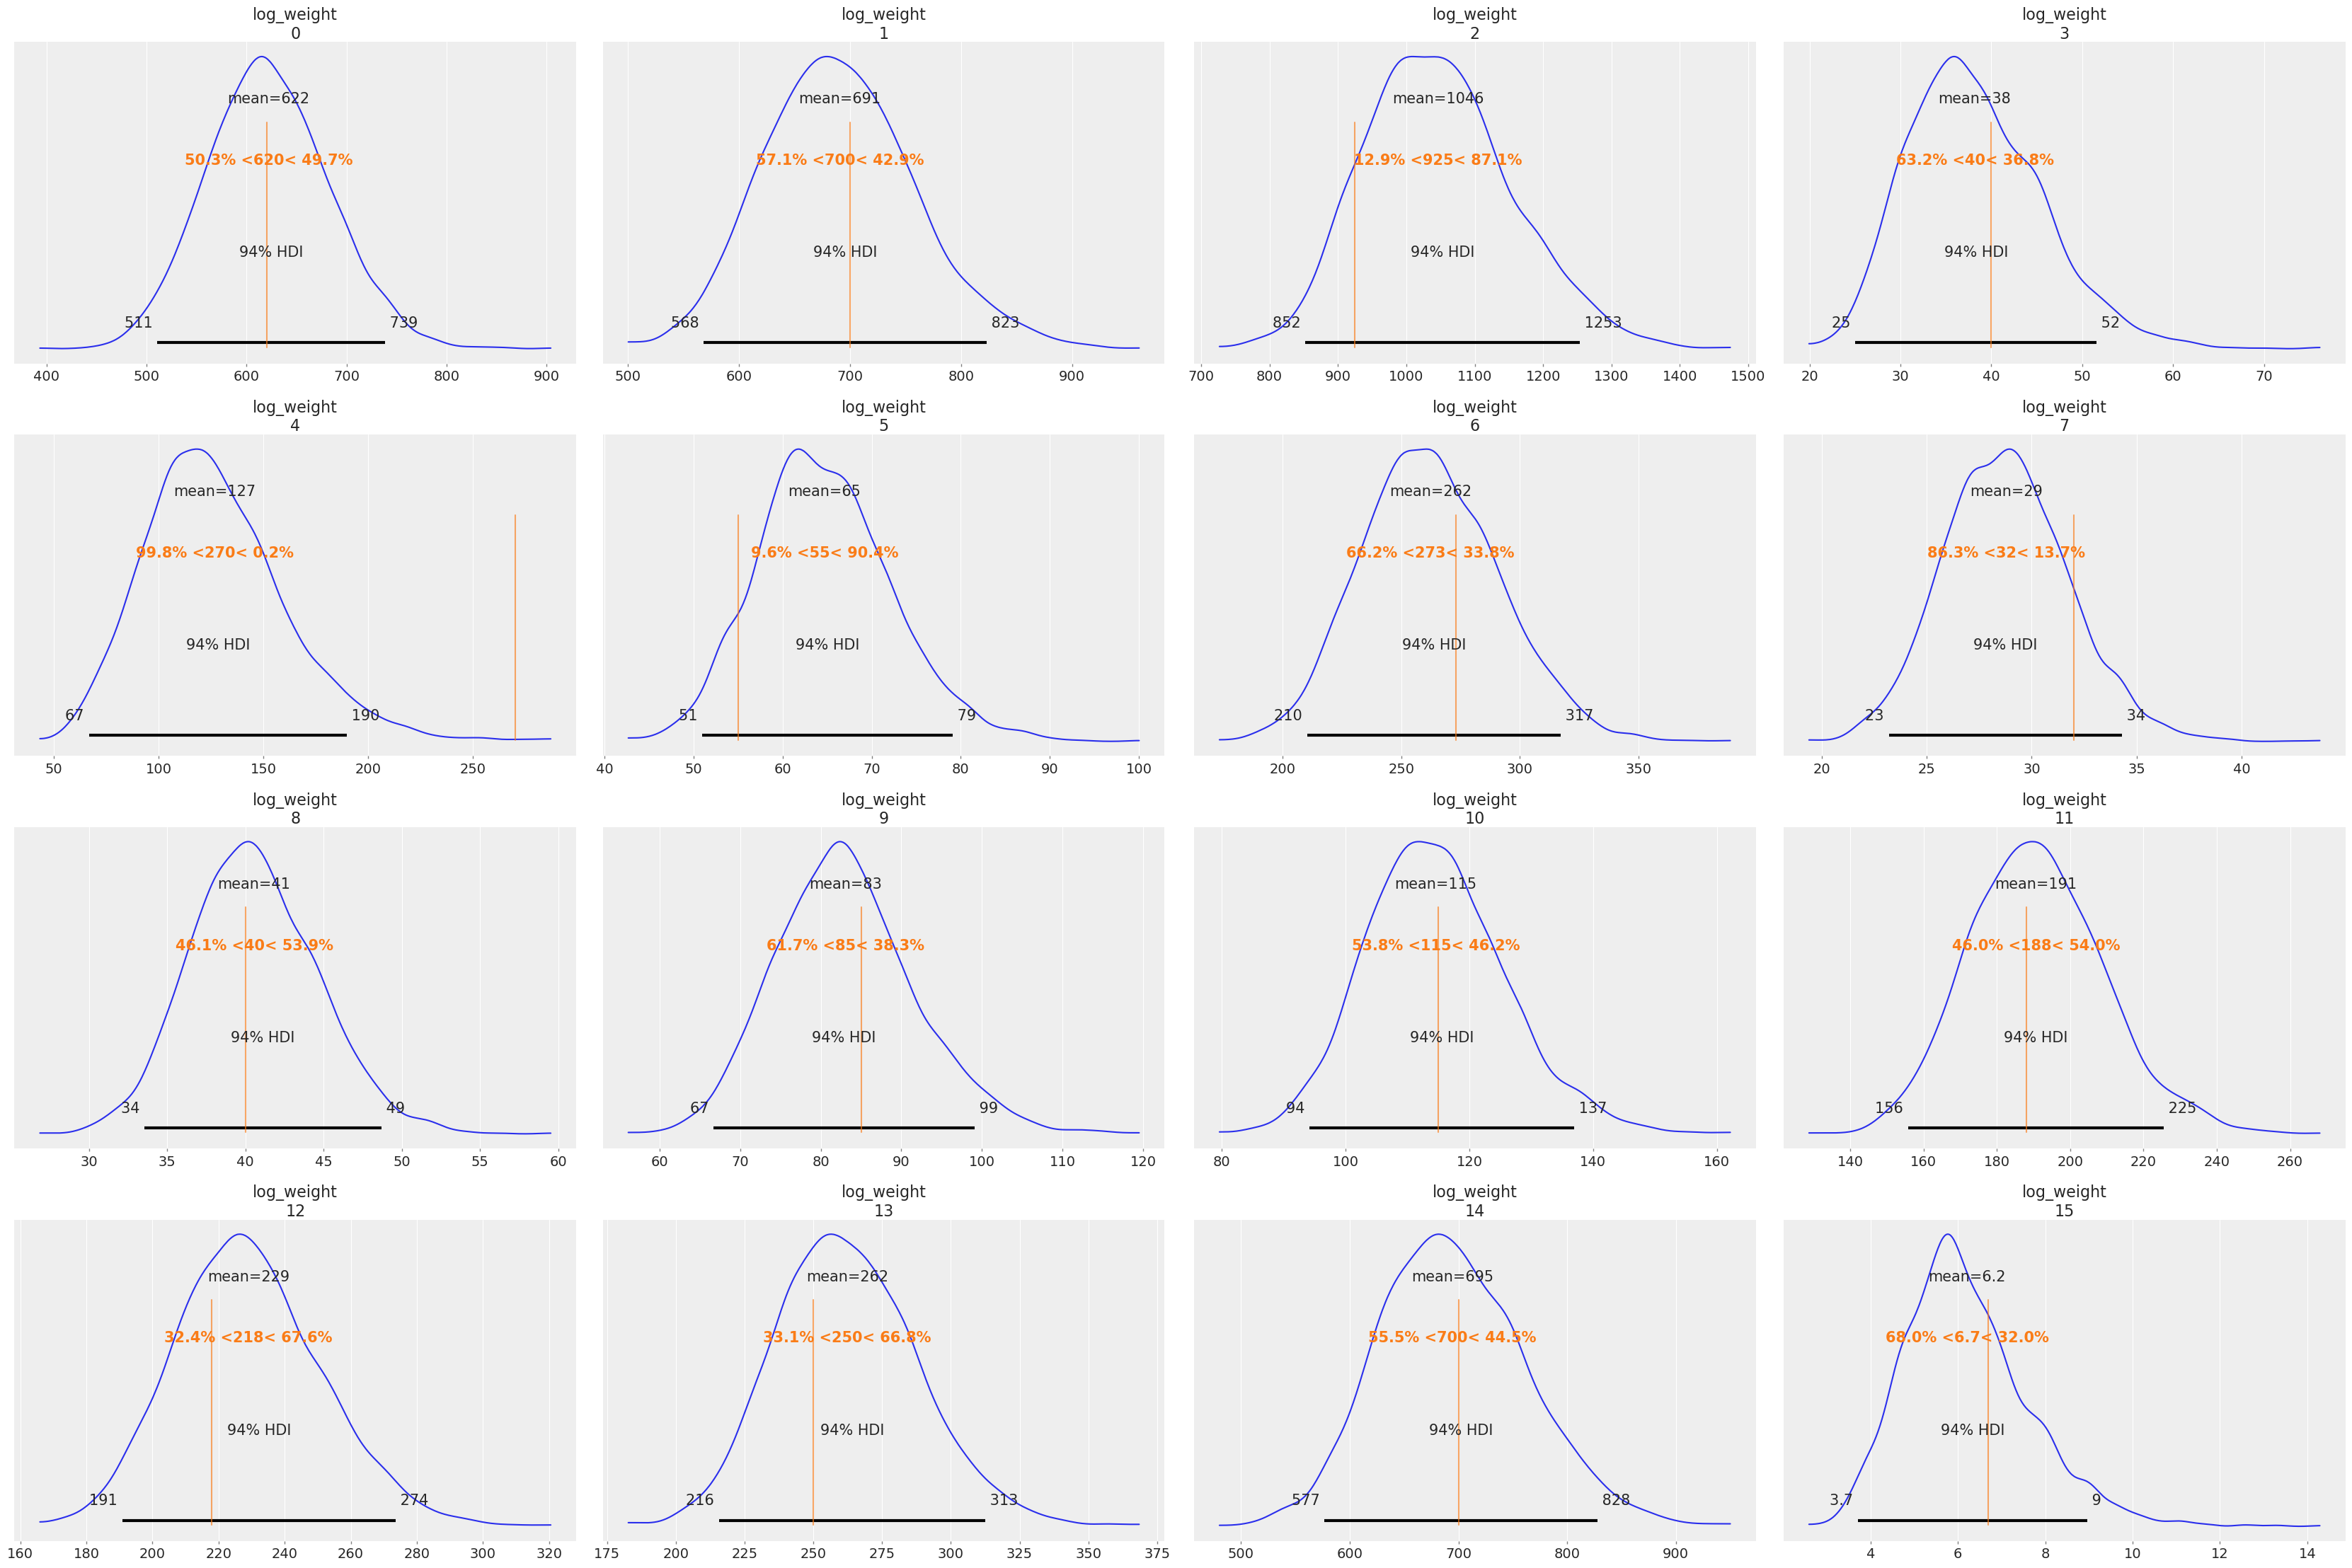

In [56]:
arviz.plot_posterior(
    idata_unpooled_oos.posterior_predictive,
    var_names=["log_weight"],
    ref_val=oos_data.Weight.tolist(),
    transform=np.exp,
);

## Summary

- Linear regression is a very versatile kind of models.
- Transforming the data can make a big difference for model fitting (here we used a log transformation), but remember to transform the parameters back for easier interpretation of the model's output.
- NUTS cries loudly when it has difficulties exploring the posterior space, which forces the modeler to pay attention to the problems in their models.
- PyMC3 helps you focus on model building and improvement without specialized knowledge about fitting algorithms.
- ArviZ is your friend for all pre- and post-processing modeling steps.
- PyMC3 usually does a good job of automatically imputing missing data points for you. Keep in mind every imputation is an assumption though, which might demand more checks and caution.
- PyMC3's `Data` container is really useful to make the model data-aware, thus unlocking the possibility to make out-of sample predictions.